# Sanity check to see if there is any difference between:
- (1) using an analytic calculation of a baryonification correction factor to then apply to TabCorr measurement
- (2) applying baryonification displacement to particles and then using TabCorr to calculate DS 

In [1]:
import numpy as np

from matplotlib import cm
from matplotlib import colors
import matplotlib.pyplot as plt

import pandas as pd

import time

from scipy.interpolate import splrep, splev
from scipy.integrate import quad

from halotools.sim_manager import UserSuppliedHaloCatalog, UserSuppliedPtclCatalog,FakeSim, CachedHaloCatalog
from halotools.mock_observables import delta_sigma, wp, return_xyz_formatted_array
from halotools.empirical_models import NFWProfile
from halotools.empirical_models import PrebuiltHodModelFactory, HodModelFactory
from halotools.empirical_models import AssembiasZheng07Cens, AssembiasZheng07Sats, TrivialPhaseSpace, NFWPhaseSpace
from halotools.utils import add_halo_hostid
from halotools.mock_observables.surface_density.surface_density_helpers import annular_area_weighted_midpoints

import baryonification as bfc
from baryonification.useful_functions import DeltaSigmas_from_density_profile, cvir_fct

from tabcorr import TabCorr

from astropy.cosmology import Planck15

In [2]:
redshift = (1./0.65650)-1. #z=0.523
Lbox = 1000. #Mpc/h

In [3]:
# Now, we're ready to calculate correlation functions for a specific model.
HOD_model = PrebuiltHodModelFactory('zheng07', redshift = redshift, cosmology=Planck15, populate=False,
                                         secondary_haloprop_key='halo_nfw_conc')



In [4]:
def hod_model_from_params(params, HOD_model):
    
    HOD_model.param_dict['logMmin'] = params[0]
    HOD_model.param_dict['sigma_logM'] = params[1]
    HOD_model.param_dict['logM0'] = params[2]
    HOD_model.param_dict['logM1'] = params[3]
    HOD_model.param_dict['alpha'] = params[4]
    
    return HOD_model

In [5]:
HOD_params = [13.031,0.38,13.27,14.08,0.76] #params from https://ui.adsabs.harvard.edu/abs/2014MNRAS.444..476R/abstract

HOD_model = hod_model_from_params(HOD_params, HOD_model)


##  (1) using an analytic calculation of a baryonification correction factor to then apply to TabCorr measurement

In [6]:
# We could read it in like this. Thus, we can skip the previous steps in the
# future.
halotab = TabCorr.read('mdpl2_tabCorr_DS.hdf5')

/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [7]:
baryonic_params = [2.3e13, 0.31, 4.0] #[Mc, mu, thej] Model A
# baryonic_params = [6.6e13, 0.21, 4.0] #[Mc, mu, thej] Model B

ngal, ds_baryons_in_mpc = halotab.predict_with_baryons(HOD_model,baryonic_params)
ngal, ds_in_mpc = halotab.predict(HOD_model)


length_unit_conversion = 1e6
ds_baryons_in_pc = ds_baryons_in_mpc/length_unit_conversion**2
ds_in_pc = ds_in_mpc/length_unit_conversion**2

UPDATED
Normalizing power-spectrum done!


## (2) applying baryonification displacement to particles and then using TabCorr to calculate DS 

In [8]:
# We could read it in like this. Thus, we can skip the previous steps in the
# future.
halotab_displaced = TabCorr.read('mdpl2+baryonification_tabCorr_DS.hdf5')

/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [9]:
ngal, ds_displaced_in_mpc = halotab_displaced.predict(HOD_model)


ds_displaced_in_pc = ds_displaced_in_mpc/length_unit_conversion**2

In [10]:
rbin = annular_area_weighted_midpoints(np.logspace(-1, 1, 20))

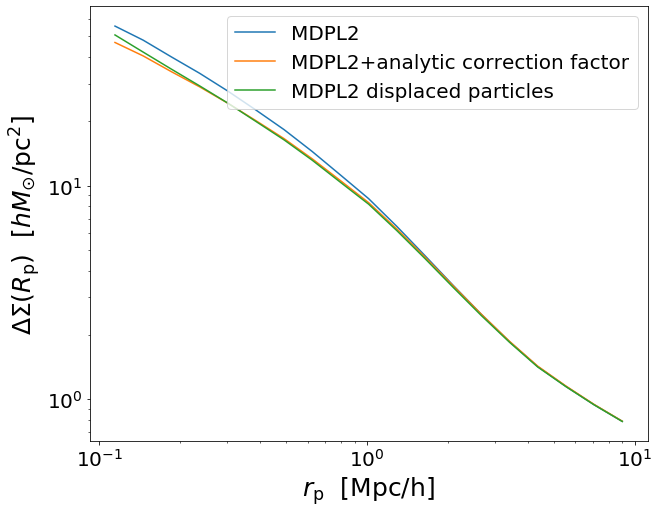

In [11]:
plt.figure(figsize=[10,8])
plt.plot(rbin,ds_in_pc, label='MDPL2')
plt.plot(rbin, ds_baryons_in_pc, label='MDPL2+analytic correction factor')
plt.plot(rbin, ds_displaced_in_pc, label='MDPL2 displaced particles')
plt.loglog()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r_{\rm p} $  $\rm{[Mpc/h]}$', fontsize=25)
plt.ylabel(r'$\Delta\Sigma(R_{\rm p})$  $[h M_{\odot} / {\rm pc}^2]$', fontsize=25)
plt.legend(loc='best', fontsize=20)
plt.show()

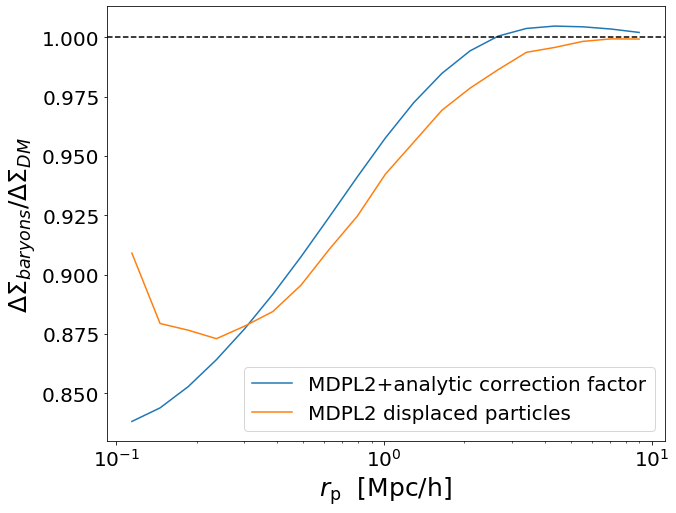

In [12]:
plt.figure(figsize=[10,8])
plt.plot(rbin, ds_baryons_in_pc/ds_in_pc, label='MDPL2+analytic correction factor')
plt.plot(rbin, ds_displaced_in_pc/ds_in_pc, label='MDPL2 displaced particles')
plt.axhline(1, linestyle='--', color='k')
plt.semilogx()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r_{\rm p} $  $\rm{[Mpc/h]}$', fontsize=25)
plt.ylabel(r'$\Delta\Sigma_{baryons}/\Delta\Sigma_{DM}$', fontsize=25)
plt.legend(loc='best', fontsize=20)
plt.show()

there was a bug in `DeltaSigmas_from_density_profile` in the integration bounds.